In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pickle
from trijunction.gate_design import gate_coords
from trijunction.constants import scale, bands, topological_gap, sides
import trijunction.trijunction as trijunction
import trijunction.optimization as optimization
import trijunction.parameters as parameters
from trijunction.tools import hamiltonian
from trijunction.utils import eigsh, svd_transformation, dict_update, dep_acc_index, order_wavefunctions, density
import kwant

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


#### Import configuration file

In [2]:
with open(os.path.realpath('config.json'), 'r') as f:
    config = json.load(f)

change_config = [
    {"device":
     {"grid_spacing":
      {"twoDEG": 0.5, "normal": 1, "dielectric": 1, "air": 5, "gate": 1, "substrate": 1}}},
    {"gate": {"channel_width": 13.0, "L":40, 'angle': np.pi/6, 'gap': 4}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
config

{'device': {'thickness': {'dielectric': 3.0,
   'twoDEG': 2,
   'gates': 2,
   'substrate': 5},
  'grid_spacing': {'twoDEG': 0.5,
   'normal': 1,
   'dielectric': 1,
   'air': 5,
   'gate': 1,
   'substrate': 1},
  'permittivity': {'metal': 5000,
   'twoDEG': 15,
   'air': 1.0,
   'Al2O3': 9.1,
   'substrate': 16}},
 'gate': {'L': 40,
  'channel_width': 13.0,
  'gap': 4,
  'angle': 0.5235987755982988},
 'kwant': {'nwl': 150, 'nww': 7}}

#### Create an instance of Trijunction class with the predefined or new configuration

In [3]:
%%capture output
%%time
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

#### Look at the discretized trijunction

In [5]:
sites = np.array([site.pos for site in system.trijunction.sites])/1e-9
gates = system.poisson_system.regions.voltage.tag_points
gate_names = np.array(list(gates.keys()))
non_depletion_gates = [gate.startswith(('global', 'dirichlet')) for gate in gate_names]
depletion_gates = gate_names[np.logical_not(non_depletion_gates)]
full_grid = system.grid_points *(scale/1e-9)

In [8]:
list(gates.keys())

['left_1',
 'left_2',
 'right_1',
 'right_2',
 'top_1',
 'top_2',
 'global_accumul',
 'dirichlet_0',
 'dirichlet_1',
 'dirichlet_2',
 'dirichlet_3',
 'dirichlet_4',
 'dirichlet_5']

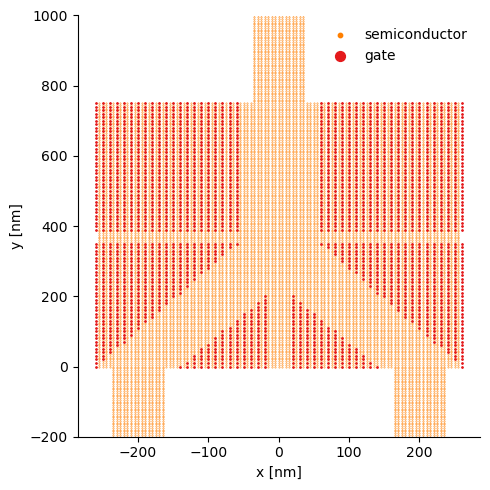

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#https://gist.github.com/thriveth/8560036
CB_friendly_color = ['#ff7f00', '#e41a1c'] 

plt.scatter(sites[:, 0], sites[:, 1], s = 0.1, c = CB_friendly_color[0], 
            label = 'semiconductor')
for i, gate in enumerate(depletion_gates):
    gate_sites = full_grid[gates[gate]]
    if i == 0: 
        label='gate'
    else: 
        label = ''
    plt.scatter(gate_sites[:, 0], gate_sites[:, 1], 
                s = 0.5, 
                c = CB_friendly_color[1],
               label = label)
    
    
plt.legend(markerscale=10, frameon=False)
plt.xlabel('x [nm]')
plt.ylabel('y [nm]')

plt.ylim(-200, 1000)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

fig.tight_layout()

plt.savefig('figures/trijunction.png', format='png')

#### Plot Majorana wavefunctions in the nanowire

In [ ]:
voltages = parameters.voltage_dict([-7e-3, -6.8e-3, -7e-3, -7e-3])
summed_ham = sum(
    [
        voltages[key] * system.linear_terms[key]
        for key, value in system.linear_terms.items()
    ]
)
numerical_hamiltonian = system.base_ham + summed_ham


eigval, eigvec = trijunction.utils.eigsh(
    numerical_hamiltonian, 6, sigma=0, return_eigenvectors=True
)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6, 6), sharey=True)
for i in range(3):
    kwant.plotter.density(system.trijunction, 
                          trijunction.utils.density(eigvec.T[i]),
                          ax=ax[i],
                          colorbar=False);
    ax[i].set_xlabel('x [m]', loc='left')
ax[0].set_ylabel('y [m]')
plt.savefig("figures/decoupled_wavefunctions.png", format='png');

### Run optimization routine
Note: It takes about 30minutes or so in a single core depending on the specified configuration. Hence please 
save your results often.

In [131]:
# Import parameters

pair = 'left-right'
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())

index = system.indices.copy()

# Set-up for specific pair to be optimized
# remove 50% of the points from the channel to be depleted that is closest to the center.
depleted_channel = list(set(sides)-set(pair.split('-')))[0]
depleted_indices = index[depleted_channel]
index[depleted_channel]  = depleted_indices[:int(len(depleted_indices)*50/100)]

params['dep_acc_index'] = index

initial_condition = (-3e-3, -3e-3, -3e-3, 10e-3)

##### Step1: Optimize potential shape

In [ ]:
args = (pair.split('-'),
        (system.base_ham, system.linear_terms),
        params['dep_acc_index'], 
        )

sol1 = minimize(shape_loss, 
         x0=initial_condition, 
         args=args, 
         method='trust-constr', 
         options={'initial_tr_radius':1e-3}
        )

##### Step3: Optimize phase

In [ ]:
initial_condition = sol2.x

params.update(parameters.voltage_dict(initial_condition))

args = (pair, 
        params, 
        (system.trijunction, 
         system.linear_terms, 
         system.f_params,
         system.mlwf[order_wavefunctions(pair)]
        )
       )

sol3 = minimize_scalar(loss,
                        args=args, 
                        method='bounded',
                        bounds=(0,2),
                      )


phase = sol3.x

##### Optimize Majorana couplings

In [ ]:
params.update(parameters.phase_pairs(pair, phase*np.pi))

base_ham = system.trijunction.hamiltonian_submatrix(
    sparse=True, params=system.f_params(**params)
)

args = (pair, 
        params, 
        (base_ham, system.linear_terms, 
         None,
         system.mlwf[order_wavefunctions(pair)]
        ),
       )

sol4 = minimize(loss, 
         x0=sol2.x, 
         args=args, 
         method='trust-constr', 
         options={
             'initial_tr_radius':1e-3,
         }
        )

#### Computations at a hpc machine 

We run the optimization routine at a remote hpc core and continue working in asynchronous mode.
Then we retrieve our results from the remote machine and plot them here.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6, 6), sharey=True)

for i, pair in enumerate(['left-right', 'left-top', 'right-top']):
    
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    
    with open(os.path.realpath("data/"+pair+".pkl"), 'rb') as outfile:
        results = pickle.load(outfile)

    params.update(parameters.phase_pairs(pair, results['phase']))
    params.update(results['voltages'])

    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )

    linear_ham, full_ham = hamiltonian(base_ham, 
                                       system.linear_terms, 
                                       **params
                                      )



    evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

    wfv = density(evecs[:, 0])

    kwant.plotter.density(system.trijunction, wfv, ax = ax[i]);
    
    ax[i].set_xlabel('x [m]', loc='left')
    
ax[0].set_ylabel('y [m]')


    # ax[i].xaxis.set_ticklabels([])
    # ax.yaxis.set_ticklabels([])
fig.tight_layout()

plt.savefig("figures/coupled_wavefunctions.png", format='png');